# Предсказание следующего слова или окончания для языка эсперанто
Задачей данного проекта является создание модели, которая будет предсказывать следующее слово или окончание текущего для [языка эсперанто](https://lernu.net/ru/esperanto) подобно тому, как это делают клавиатуры телефона. В рамках проекта будет реализовано две модели: одна, использующая [Марковские цепи](https://github.com/sandeepbhutani304/markov-predict-next-word/blob/master/markov_nextwordpred.py), и вторая, использующая [transformers](https://huggingface.co/blog/how-to-train).

## Метрика
В качестве метрики для оценки качества предсказаний модели я буду использовать самописную функцию, которая будет брать часть текста и сравнивать предсказанное слово с тем, что на самом деле идёт в тексте. Так как в самой задаче предполагается, что модель будет выводиться несколько вариантов для следующего слова (как это и делают современные телефонные клавиатуры), то учитываться должны не только самые вероятные слова, но и следующие по вероятности.
Метрика включает в себя два числа. Обы числа считаются, как отношения количества угаданных случаев (слово есть среди предсказанных) на общее количество случаев, но первое число метрики ещё учитывает какую позицию слово занимало в предсказании: если слово было первым среди предсказанных, то оно получает 1 балл, если вторым, то 0,75, третьим – 0,625, т.е. *0,5 + 1 / (2 ^ top)*

In [25]:
def metric(model, seq_len=2, top=3, test_data="../data/test-pure.txt"):
    from tqdm import tqdm
    data = open(test_data, encoding="utf-8").read().split("\n")
    data = [line.split() for line in data]
    s = 0
    s2 = 0
    n = 0
    for line in tqdm(data):
        for i in range(len(line) - seq_len):
            n += 1
            if seq_len > 1:
                sent = " ".join(line[i:i+seq_len])
            else:
                sent = line[i]
            pred = model(sent)[:top]
            if len(pred) == 0:
                continue
            t = 1
            for w in pred:
                if w == line[i+seq_len]:
                    s += 0.5 + 1 / (2 ** t)
                    s2 += 1
                    continue
                t += 1
    return (s/n, s2/n)

## Данные
Для обучения был взят корпус текса с сайта https://oscar-corpus.com/ размером ~300Мб, содержащий 974367 строчек на языке эсперанто, которые были получены с помощью веб-кроулера. В качестве тестового корпуса был взят корпус Newscrawl с сайта https://wortschatz.uni-leipzig.de/en/download/esperanto, содержащий 1М записей, из которых случайным образом я взял 1000 записей.

In [21]:
data = [line.strip("\n") for line in list(open("../data/newscrawl.txt", encoding="utf-8"))]

import random
random.seed(42)
random.shuffle(data)

f = open(f'../data/data-test.txt', 'w+', encoding="utf-8")
f.write("\n".join(data[:1000]))
f.close()

## Подготовка данных
Я написал модуль для работы с языком эсперанто. Он способен убрать пунктуацию и спецсиволы из слова, а так же дать вектор, описывающий данное слово (который, увы, мне не пригодился 😔).
Для модели, использующей Марковские цепи я очистил вообще весь текст от пунктуации и спец символов, удалил слова из одной буквы, т.к. такие не существуют в языке. Аналогично я сделал для тестового корпуса.
Для модели, использующей трансформеры, мы будем использовать токенайзер.

In [2]:
# Подгружаем библиотеку для работы с эсперанто
import sys
sys.path.insert(0,'../lib')
from Esperanto import Esperanto as esp

In [5]:
# Функции для чистки текста
def clean_str(text):
    from nltk.tokenize import WordPunctTokenizer
    tokenizer = WordPunctTokenizer()

    return " ".join([esp(word).text for word in tokenizer.tokenize(text) if esp(word).is_word() and len(esp(word).text) > 1])

def clean_text(text):
    return "\n".join(clean_str(line) for line in text.split("\n"))

In [23]:
# Удаление пунктуации и спецсимволов
f = open("../data/eo-train.txt", encoding="utf-8")
data = f.read()
f.close()

f = open("../data/eo-train-pure.txt", "w+", encoding="utf-8")
f.write(clean_text(data))
f.close()

f = open("../data/data-test.txt", encoding="utf-8")
data = f.read()
f.close()

f = open("../data/test-pure.txt", "w+", encoding="utf-8")
f.write(clean_text(data))
f.close()

Для модели с трансформерами всё гораздо сложнее в плане подготовки данных...

In [ ]:
# Использование токенайзера

# Создание модели для токенайзера
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer

paths = [str(x) for x in Path("../data/").glob("**/eo.txt")]

tokenizer = ByteLevelBPETokenizer()

tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

tokenizer.save_model("../models")

In [ ]:
# Загрузка токенайзера из полученных ранее файлов
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing


tokenizer = ByteLevelBPETokenizer(
    "../models/vocab.json",
    "../models/merges.txt",
)

tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

Поскольку модель похожа на [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), мы обучим ее задаче моделирования маскированного языка, то есть предсказанию того, как заполнить произвольные маркеры, которые мы случайным образом маскируем в наборе данных

In [ ]:
# Конфигурация модели
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [ ]:
# Воссоздадим наш токенизатор в трансформаторах
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("../models", max_len=512)

In [ ]:
# Инициализируем модель
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [ ]:
# Создаём датасет для модели
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="../data/eo-train.txt",
    block_size=128,
)

Помощник, который поможет нам объединить различные образцы набора данных вместе в объект, на котором PyTorch знает, как выполнить backprop:

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

## Построение и обучение моделей

### Модель на цепях Маркова

In [11]:
import pandas as pd
from tqdm import tqdm

# Переменные, в которых хранится информация модели
first_possible_words = {}
second_possible_words = {}
transitions = {}

# Вспомогательные функции
def expandDict(dictionary, key, value):
    if key not in dictionary:
        dictionary[key] = []
    dictionary[key].append(value)
    
def get_next_probability(given_list):
    probability_dict = {}
    given_list_length = len(given_list)
    for item in given_list:
        probability_dict[item] = probability_dict.get(item, 0) + 1
    for key, value in probability_dict.items():
        probability_dict[key] = value / given_list_length
    return probability_dict

# Функция для обучения
def trainMarkovModel(data):
    from nltk.tokenize import WordPunctTokenizer
    
    tokenizer = WordPunctTokenizer()
    data_tok = [tokenizer.tokenize(line.lower()) for line in data]
       
    for line in tqdm(data_tok):
        tokens = [str(esp(i)) for i in line if esp(i).is_word()]
        tokens_length = len(tokens)
        for i in range(tokens_length):
            token = tokens[i]
            if i == 0:
                first_possible_words[token] = first_possible_words.get(token, 0) + 1
            else:
                prev_token = tokens[i - 1]
                if i == tokens_length - 1:
                    expandDict(transitions, (prev_token, token), 'END')
                if i == 1:
                    expandDict(second_possible_words, prev_token, token)
                else:
                    prev_prev_token = tokens[i - 2]
                    expandDict(transitions, (prev_prev_token, prev_token), token)
    
    first_possible_words_total = sum(first_possible_words.values())
    for key, value in first_possible_words.items():
        first_possible_words[key] = value / first_possible_words_total
        
    for prev_word, next_word_list in second_possible_words.items():
        second_possible_words[prev_word] = get_next_probability(next_word_list)
        
    for word_pair, next_word_list in transitions.items():
        transitions[word_pair] = get_next_probability(next_word_list)
    
# Функция предсказания следующего слова
def next_word(tpl, top=-1):
    if(type(tpl) == str):
        d = second_possible_words.get(tpl)
        if (d is not None):
            return pd.DataFrame(d.items(), columns=["word", "prob"]).sort_values(by="prob", ascending=False).head(top)
    if(type(tpl) == tuple): 
        d = transitions.get(tpl)
        if(d == None):
            return []
        return pd.DataFrame(d.items(), columns=["word", "prob"]).sort_values(by="prob", ascending=False).head(top)
    return None

In [9]:
# Функции для сохранения и загрузки переменных модели Маркова
import pickle
def save_obj(obj, name):
    with open('../models/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../models/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
# Загружаем очищенные данные и обучаем модель
data = open("../data/eo-train-pure.txt", encoding="utf-8").read().split("\n")
trainMarkovModel(data)

In [ ]:
# Сохраняем модель
save_obj(second_possible_words, "second_possible_words")
save_obj(transitions, "transitions")

### Модель на трансформерах

In [ ]:
# Задаём параметры для обучения
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="../models",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_gpu_train_batch_size=64,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    prediction_loss_only=True,
)

In [ ]:
# Чистим память у GPU
import torch
torch.cuda.empty_cache()

In [36]:
# Подключаем и используем TensorBoard
%load_ext tensorboard

In [37]:
%tensorboard --logdir './runs/'

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 10968.

Т.к. для отображения графиков надо запускать ноутбук, то вот скриншот с TensorBoard:
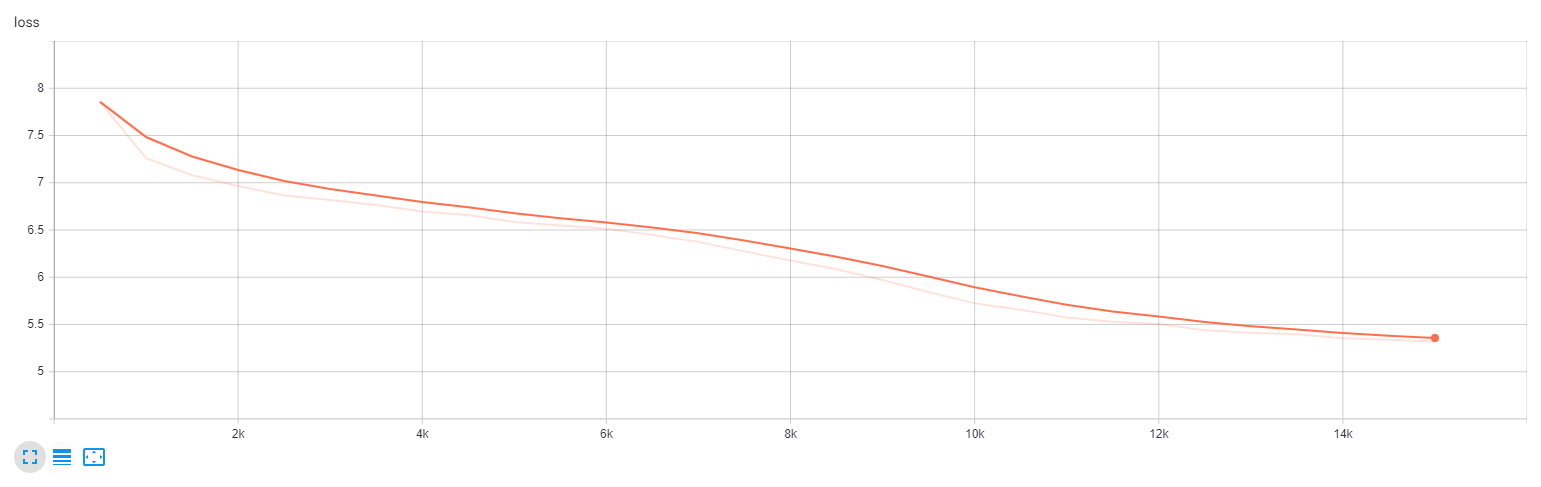

In [ ]:
trainer.train()

In [ ]:
# Запускаем обучение моделт
trainer.train()

In [ ]:
# Сохраняем полученную модель
trainer.save_model("../models")

## Оценка полученных моделей

### Оценка модели на цепях Маркова

In [10]:
# Функция для работы с нашей функцией метрики
def Markov_model(text):
    if text.find(" ") != -1:
        text = tuple(text.split())
    pred = next_word(text)
    if pred is None or len(pred) == 0:
        return []
    return list(pred.word.values)

In [13]:
# Загружаем модель
second_possible_words = load_obj("second_possible_words")
transitions = load_obj("transitions")

In [26]:
# Смотрим метрики для ТОП3 предсказанных слов на основе одного предыдущего слова
metric(Markov_model, seq_len=1, top=3)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.71it/s]


(0.10794935211570515, 0.11731813538362278)

In [27]:
# Смотрим метрики для ТОП5 предсказанных слов на основе двух предыдущих слов
metric(Markov_model, seq_len=2, top=5)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.77it/s]


(0.13688455309960793, 0.15608841411443833)

## Оценка модели на трансормерах

In [16]:
# Загружаем модели
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="../models",
    tokenizer="../models"
)

In [32]:
# Функция для работы с нашей функцией метрики
def transf_model(text):
    text += " <mask>."
    fm = fill_mask(text)
    res = []
    for i in fm:
        res.append(esp(i['token_str'].strip('Ġ')).text)
    return res

In [34]:
# Смотрим метрики для ТОП3 предсказанных слов на основе одного предыдущего слова
metric(transf_model, seq_len=1, top=3)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:52<00:00,  1.40it/s]


(0.003931662992634013, 0.0048389698370880155)

In [35]:
# Смотрим метрики для ТОП5 предсказанных слов на основе двух предыдущих слов
metric(transf_model, seq_len=2, top=5)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:44<00:00,  1.42it/s]


(0.03680606852662083, 0.04875277004375249)

## Выводы
Грусть-печаль(( Куча убитого времени и нервов, перебор кучи разных моделей, но в итоге мои трансформеры, на которые я так расчитывал, оказались на порядок-два хуже, чем самая простоя модель на цепях Маркова, да ещё и предсказывает дольше.

At least i tried...😔